
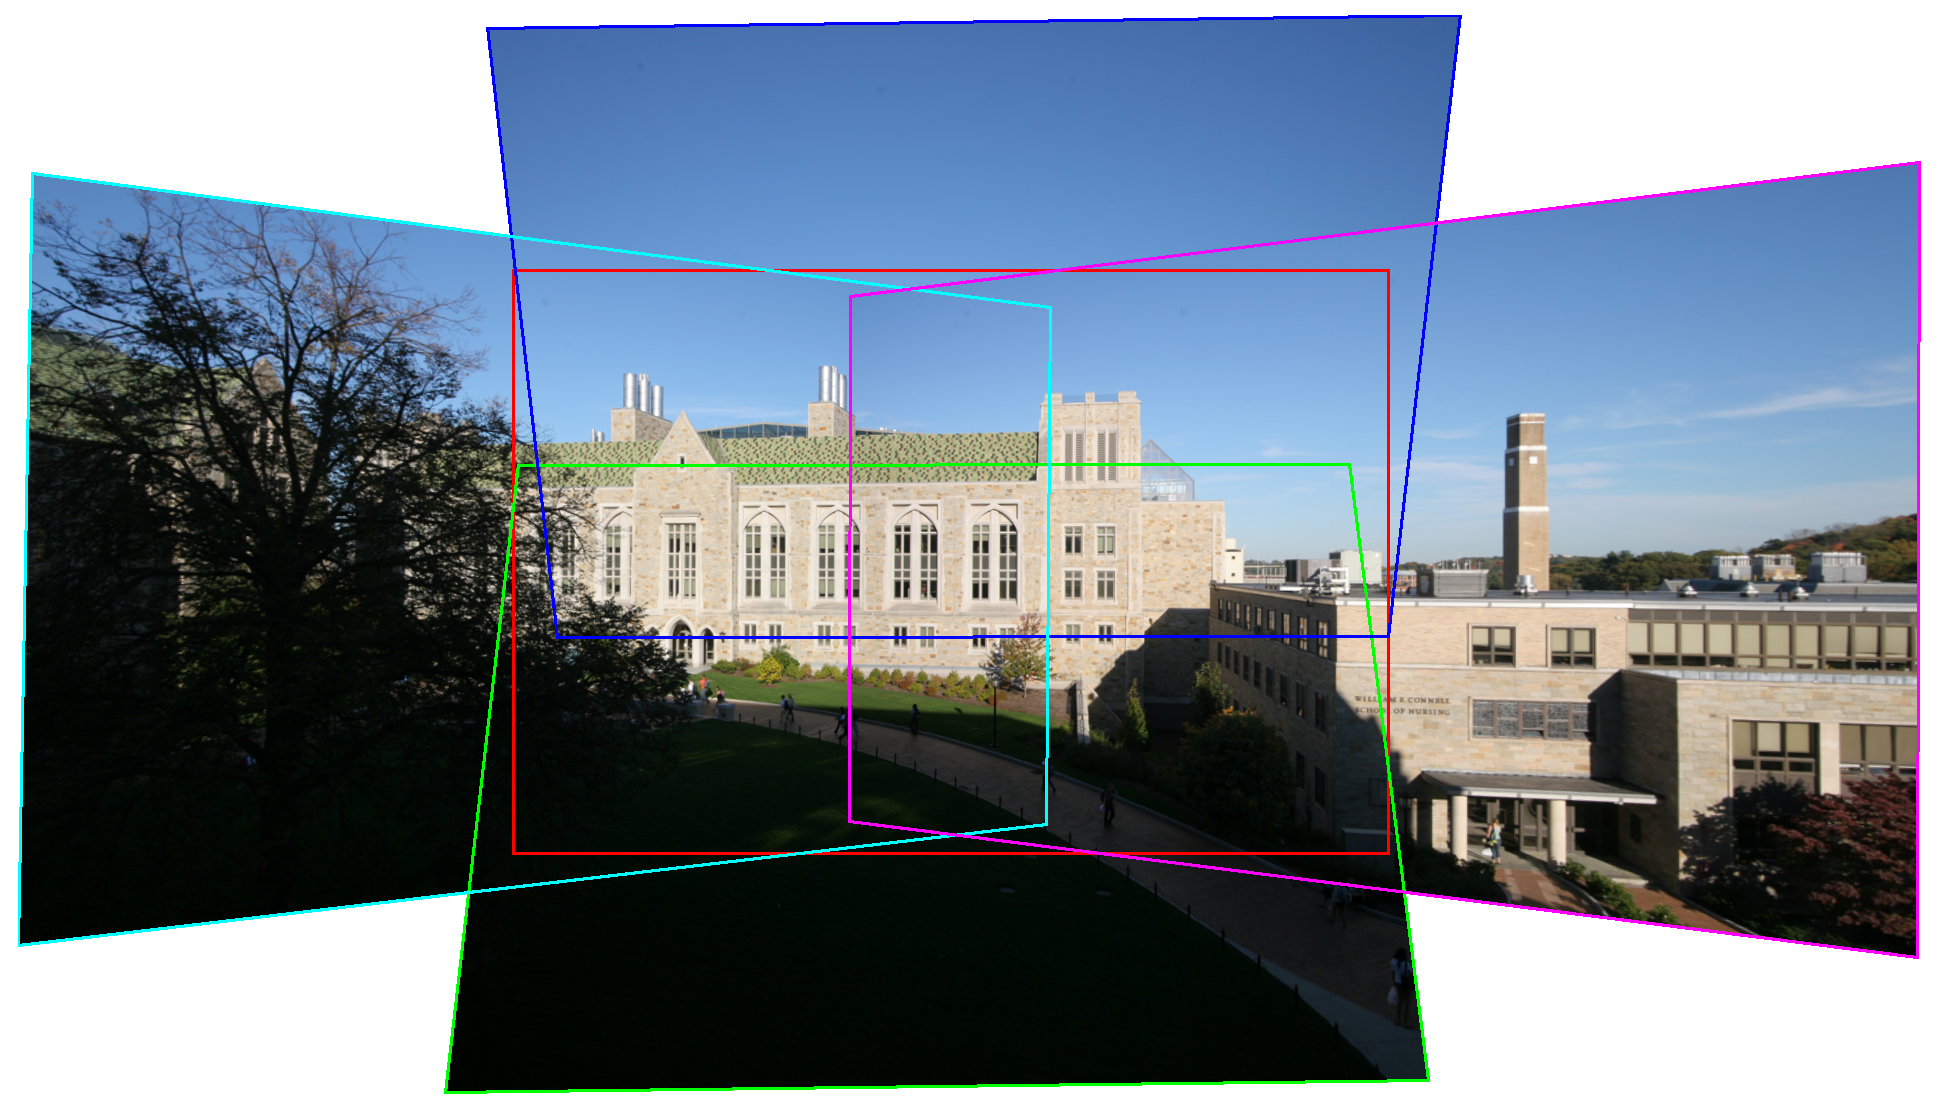

# Creating Image Mosaics using Homographies 

In this assignment, you will align and blend together multiple photographs 
to form a panorama mosaic that extends the field of view of a camera.

When two images are taken with same center-of-projection, they can be aligned with a
homography transformation. To estimate the correct warping, you'll need at
least 4 pairs of corresponding points in the overlaping region. You'll mark these
points manually (later in the quarter we will discuss some methods for finding
such points automatically without user input) and compute a transformation that 
aligns them.

The the source images for alignment are available via Canvas in the assignment
directory. In addition I have provided a module **selectpoints.py** which 
contains some code for capturing user clicks. You should download all three files
and unzip them into the same directory as this notebook.

**To start with, please enter your name and student ID # in the cell below**

***
**Name:**

**SID:**
***

In [ ]:
#tell ipython that we are running in a notebook. 
#this is necessary for the interactive user interface in part 1 below
%matplotlib notebook     

#import a few key modules, these should be sufficient to complete the assignment
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom
import pickle

#import the provided functions to support point selection in the notebook
import selectpoints


***
# 1. Point Correspondence [5 pts]

The first image in each example provided is the central image.  It's simplest
to construct a mosaic from a central image and a set of peripheral images,
since we then need to find just one homography for each peripheral image. You
should flesh out the code below to allow the user to manually select at least
4 pairs of correpsonding points between each central and peripheral image. 
These points should be located on distinctive locations that you can easily 
identify between the images such as high contrast corners.

Write code below which loads in the central image and then loops over the
remaining images and for each image allows you to select four or more points.
Save out the resulting points to a pckl file which you will include as part of 
your upload. You should encapsulate the basic procedure of getting the point 
correpsondences in a function called **get_correspondences** to make it easier 
to run on different sets of images to produce your final results

I have provided some code which takes care of getting user clicks in the file
**selectpoints.py**.  It takes as input the plot axis and the number of points 
you want from the user. As you click, the points are numbered so that you can 
make sure points correspond in the two images you are trying to align.
<tt>
sp = select_k_points(ax,npoints)
</tt><p>
Once you have finished marking **npoints** locations in the plot, you can access 
their coordinates via the fields **sp.xs** and **sp.ys**


NOTES:

1. Make sure you read through the code in **selectpoints.py** so you understand 
how it works before proceeding.

2. In an interactive application you would need to write code to wait until the user
finished clicking before accessing <tt>sp.xs,sp.ys</tt> but here in the notebook
environment we will just split the code into two different cells and only execute
the second one after clicking on all the points

3. If you are running into memory limits, you should downsample the images
when you load them in (e.g. using use **scipy.ndimage.zoom**) to make things more manageable
and run faster.


In [ ]:
def get_correspondences(imnames,baseim,npoints=4):
    
    """
    The function loads in a set of images which are going to be assembled
    in to a mosaic. It displays the central (base) image along with each
    peripheral image and allows the user to click to to select corresponding
    points between the base image and the peripheral image. It returns the
    images along with the user input. If the original image files were in 
    color the function converts them to grayscale. 
    
    Parameters
    ----------
    imnames : list of str
        Filenames of image files that are going in to the mosaic
    
    baseim : int
        An index which specifies which of the image files is the base image
        
    npoints : int
        How many points are required from the user. Defaults to 4
        
    Returns
    -------
    imgs : list of 2D float arrays
        The arrays for the corresponding images given in imnames. These 
        are gray scale images represented as floats.   
     
    pointmatches : list of SelectPoints objects
        Returns an object whose fields xs and ys contain the point 
        coordinates once the user has clicked  (see selectpoints.py)
        
    """

    nimages = len(imnames)

    #loop over images and load in each one and convert to grayscale
    imgs = list()
    for fname in imnames:  
        print('loading...',fname)
        I = plt.imread(fname)
        
        #convert to float data type if necessary
  
        # downsample the image to 1/4 resolution just to make things run quicker
        I = zoom(I,0.25)
        
        ## your code here
    
        #convert from color to grayscale if necessary
  
        ## your code here
    
        #finally, store the array in our list of images
        imgs.append(I)
 
    #loop over each pair of overlapping images and have the user 
    #click to specify corresponding points
    pointmatches = list()
    for i in range(nimages):
        if (i==baseim):
            continue
        
        fig = plt.figure()
    
        #select points in base image
        ax1 = fig.add_subplot(2,1,1)
        ax1.imshow(imgs[baseim],cmap=plt.cm.gray)
        sp1 = selectpoints.select_k_points(ax1,npoints)

        #corresponding points in overlapping image
        ax2 = fig.add_subplot(2,1,2)
        ax2.imshow(imgs[i],cmap=plt.cm.gray)
        sp2 = selectpoints.select_k_points(ax2,npoints)
 
        pointmatches.append((sp1,sp2))

    return imgs,pointmatches


The following three cells demonstrate the functionality of your **get_correspondences** function. As noted above, they should be executed one at a time.  First execute the first cell which should display two pairs of images and get the user clicks. Once you have finished clicking, execute the second cell which grabs the point coordinates where the user clicked and saves the results out to disk. The third cell demonstrates loading the data back in from disk and visualizing the points again.  Once you have finished implementing **get_correspondences** you should execute these cells including the final visualization step so that the results are visible in your saved notebook pdf.

In [ ]:
imnames = ('atrium/IMG_1347.JPG','atrium/IMG_1348.JPG','atrium/IMG_1349.JPG')
baseim = 0   #index of the central base image that we will align everything to

#make the default figure size larger to make clicking points easier
#feel free to adjust this to suit your monitor / display size
plt.rcParams['figure.figsize'] = [9, 14]

#call your function to get user clicks
imgs,pointmatches = get_correspondences(imnames,baseim)

#reduce the figure size a bit for visualizations later in the notebook
plt.rcParams['figure.figsize'] = [9, 9]

# after executing this cell, we need to stop and click before running to the next cell

In [ ]:
# collect together all the point coordinates into numpy arrays
nimages = len(imnames)
srcpts = list()
basepts = list()
for i in range(nimages-1):
    basepts.append(np.array((pointmatches[i][0].xs,pointmatches[i][0].ys)))
    srcpts.append(np.array((pointmatches[i][1].xs,pointmatches[i][1].ys)))
    
# save everything out to a file so we don't have to click again.
f = open('atrium_correspondeces.pckl','wb')
pickle.dump((baseim,imgs,srcpts,basepts),f)
f.close()

In [ ]:
# later on we can quickly read back in the variables and visualize them
f = open('atrium_correspondeces.pckl','rb')
baseim,imgs,srcpts,basepts = pickle.load(f)
f.close()

fig = plt.figure()

#plot all the base points on the base image
fig.add_subplot(2,2,1).imshow(imgs[0],cmap=plt.cm.gray)
for i in range(2):
    
    ## your code here

#plot the src points on the peripheral images
for i in range(2):
    
    ## your code here

plt.show()

***
# 2. Homography Transformations [20 pts]

For each image, we will need to compute the homography (3x3 transformation matrix) 
using linear least squares. This transformation should map the points in the 
peripheral image that you clicked to their corresponding points in the base 
"central" image. For the central image itself, this transformation would just be 
the identity matrix.

For this part you should write two functions. The first function, **compute_homography**
should estimate a transformation matrix H given the pairs of points.  The second function,
**apply_homography** should take as input an array of point coordinates and a 3x3 matrix 
and return the transformed coordinates.

Note that if the matrix <tt>H</tt> maps (x1,y1) to (x2,y2), then the inverse
mapping is given simply by inverting the matrix.  So applying the homography
<tt>inv(H)</tt> will map (x2,y2) back to (x1,y1).

You will want to use **np.linalg.lstsq** to solve for the coeffecients of H.


In [ ]:
def compute_homography(pts1,pts2):
    """
    Computes the 3x3 transformation matrix (homography) that when applied to pts1 yields pts2
    
    
    Parameters
    ----------
    pts1 : 2xN array
        2D coordinates of points (to warp)

    pts2 : 2xN array
        target 2D coordinates where points should end up

    Returns
    -------
    numpy.array (dtype=float)
        3x3 array containing the matrix H
        
    """

    #expected dimensions of input
    assert(pts1.shape[0]==2)
    assert(pts2.shape[0]==2)
    assert(pts1.shape[1]>=4)
    assert(pts2.shape[1]>=4)
    
    #
    #your code goes here
    #
    
    #expected dimension of output
    assert (H.shape==(3,3))
    
    return H 


In [ ]:
def apply_homography(H,pts):
    """
    Apply a specified homography H to a set of 2D point coordinates
    
    Parameters
    ----------
    H : 3x3 array
        matrix describing the transformation

    pts : 2xN array
        2D coordinates of points to transform
        
    Returns
    -------
    numpy.array (dtype=float)
        2xN array containing the transformed points
        
    """

    #assert expected dimensions of input
    assert(H.shape==(3,3))
    assert(pts.shape[0]==2)
    assert(pts.shape[1]>=1)
    
    #your code goes here
    
    
    #make sure transformed pts are correct dimension
    assert(tpts.shape[0]==2)
    assert(tpts.shape[1]==pts.shape[1])
    
    return tpts


## Testing

You should enter some test cases in the cell below to verify that your code is working as expected.  I've given a couple examples but you should fill out the others and add your own.

In [ ]:
# since there may be some numerical imprecision, specify a small error tolerance
tol = 1e-10

### testing apply homography

#
# If you apply the identity transformation you should get back the same points
#
pts1 = np.random.random((2,4))
H = np.array([[1.,0,0],[0,1,0],[0,0,1]])
pts2 = apply_homography(H,pts1)
err = np.mean(np.abs(pts1-pts2))
assert(err<tol)

#
# If you apply H to some points and then inv(H) to the results, you should get back the points you started with
#

#your code here


### testing computeHomography
#
# NOTE: make sure you don't try to estimate a homography for cases where three or
# four of the points are in a line since this will lead to an underdetermined 
# linear system
#

#
# If you compute the homography between a set of points and itself, you should get back the identity matrix
#

#your code here

#
# If you compute the homography between a set of points and those points multipled by two, you should get
# back a matrix which looks like a simple scaling  (i.e. 2 2 1 on the diagonal)
#
pts1 = np.array([[0.,0,1,1],[0.,1,1,0]])
pts2 = 2*pts1
H = compute_homography(pts1,pts2)
Htrue = np.array([[2.,0.,0.],[0.,2.,0],[0.,0.,1]])
err = np.mean(np.abs(H-Htrue))
assert(err<tol)


#
# If you generate two random sets of points and compute the homography between them, then apply the
# estimated homography to the first set of points, you should get back the second set.
#

#your code here



***

# 3. Warping [20pts]

Implement a function called **warp_images** which takes the collection of correspondences
and generates warped versions of all the input images to align them with the final mosaic.

1. We will use the central image's coordinate system for the final mosaic.  You
first need to figure out how big the final mosiac will be.  You can accomplish
this by determining where the corners of each source image will be mapped to in
the final mosaic (using your **apply_homography** function) and then use min/max to
determine the left-most, right-most, top-most and bottom-most points across all
of the warped images.    After this step you will have determined that all the
warped image pixels from all the images will fall inside some rectangular region
*(xmin,ymin)-(xmax,ymax)*.  Note that these coordinates will be expressed with respect 
to your central image. For example, *xmin* will be a negative value if some of the images
in your mosaic are mapped to the left of your central image.<p>

2. Generate the coordinates of all the pixels for you final mosaic as well as the
coordinates of pixels in each source image (I suggest using **np.mgrid** for this). 
To get the warped image coordinates, apply the estimated homography to the source
image pixel coordinates to determine where they will fall in the output mosaic.<p>

3. To produce the warped image, we will use **scipy.interpolate.griddata** to 
perform interpolation gray values onto a regular grid. We need to provide **griddata** 
with three pieces of information: the coordinates of the pixels after we have warped 
them with the appropriate homography, the gray value for each of those pixels, and 
the grid of pixel coordinates for our final mosaic. We will ultimately call this warping 
function for each source image, resulting in a new warped image the size of the final 
mosaic containing. By default, **griddata** will set the value of any pixels that are 
outside the source image to NaN. The figure below shows examples of warped images where 
the white pixels correspond to regions outside the source image (i.e. filled with NaNs).<p>


In [ ]:
def warp_images(imgs,baseim,srcpts,basepts):
    """
    Warp a collection of images to align them with a central base image using 
    provided point correspondences to estimate the warping.
    
    
    Parameters
    ----------
    imgs : list of 2D numpy.array (dtype=float)
        The arrays containing the input grayscale images  
  
    baseim : int
        The index of the image which is the central base image
        
    srcpts: list of 2D numpy.array, each of size 2xNclicks 
        x,y coordinates of points clicked by the user for each peripheral image

    basepts : list of 2D numpy.array, each of size 2xNclicks
        x,y coordinates of correponding locations in the base image
        
    Returns
    -------
    imgs_warped: list of 2D numpy.array (dtype=float)
        list of the resulting warped images, all of which will have the same shape
        
    """

    # first estimate all the homographies
    homs = list()
    for i in range(len(imgs)):
        if (i == baseim):
            H =  #identity matrix
        elif:
            H = compute_homography(...) #compute homography based on clicked points
        homs.append(H)
    
    # compute where the corners of each warped image end up
    # and the upper left and lower-right corners of a rectangle
    # that will enclose all of them
    ul = np.array([0,0])
    lr = np.array([0,0])
    for i in range(len(imgs)):
        #original coorner coordinates
        cx = np.array([...])
    
        #warped coordinates
        cx_warped = apply_homography(homs[i],cx)
        
        ul = np.min(...)
        lr = np.max(...)
    
    #round these to integer valued coordinates
    ul = np.floor(ul)
    lr = np.floor(lr)
    
    # for debugging purposes, you may find it very useful at 
    # this point to use plt.plot to plot out the warped 
    # corner locations and the bounding rectangle in the 
    # code above.  
    
    
    # generate the coordinates of pixels in the output image that
    # cover the bounding rectangle determined above
    ogrid_y,ogrid_x = np.mgrid[...]
    
    # loop over each input and warp it
    imgs_warped = list()
    for i in range(len(imgs)):
        
        #input pixel grid
        igrid_y,igrid_x = np.mgrid[...]
        
        # reshape igrid_y and igrid_x into a 2xN array so we can use
        # our applyHomography function on them.  you can do
        # this with some combination of flatten() and stack()
        incoords = ....
 
      
        # transform pixel coordinates
        warpedcoords = apply_homography(homs[i],incoords)

        # note: griddata expects coords to be Nx2 and values to be Nx1 so
        # make sure you transpose / flatten as necessary
  
        # brightness values reshaped as a Nx1 array
        bvalues = 
        wcoords =
        
        # use griddata to warp 
        img_warped = griddata(....)
        
        imgs_warped.append(img_warped)
    
    return imgs_warped


***

# 4. Blending [35 pts]

Now that you have generated the individual warped images, we need to blend
them together into the final mosaic image.  The simplest approach is to paste 
down the pixels from each warped image in some order into the output image. 
However, as we discussed in class this can lead to bad artifacts.  Instead you 
should create a smooth blend between the images in the regions where they 
overlap. To receive full credit, you must implement some type of weighted blending
which doesn't show visual artifacts in the overlap region.

To create a blend, first compute an alpha mask for each image which is the same
size as the target output with 1s where you have values from that image. You
can start by useing **np.isnan** to get a boolean mask for each warped image that 
tells you which pixels are valid and which are invalid (were outside the source 
image).  In order to turn the binary mask into an alpha mask, you can feather 
the edges by bluring them with a Gaussian filter.  I suggest using 
**scipy.ndimage.gaussian_filter**. Since more than one image can overlap at a 
given location, the final step you will need to carry out is to normalize these 
alpha maps by the sum of the alphas across all images at that location.

To create the Gaussian filter,**gaussian_filter** takes an argument sigma which
specifies the width of the Gaussian.  You will need to experiment with the 
parameter sigma in order to get good featering of the edges. I recommend visualizing
the alpha masks as images so you can see what they look like.

NOTE: If you simply blur the binary alpha mask for an image, you will will end
up with non-zero values outside of the support of a warped image which will
cause problems when you composite them (e.g., black bands around the edge of the
image).  To get a good result, you will need to find a way to fix this!  Your 
alpha weights should satisfy the following properties:

1. The alpha weight for an image is non-zero only where the binary mask is non-zero. 
2. The alpha weight for an image should decay to zero at the edge of the mask
3. The sum of the alpha weights across the images should be 1 (except for pixels not covered by the input images)


In [ ]:
def blend_images(imgs_warped):
    """
    Blend together a collection of warped images into a mosaic 
    using alpha masks to smooth transitions between individual photos
    
    
    Parameters
    ----------
    imgs_warped : list of 2D numpy.array (dtype=float)
        The arrays containing the warped grayscale images. Assumed to have a value
        of nan value in locations where the brightness is unknown
          
    Returns
    -------
    mosaic: 2D numpy.array (dtype=float)
        The blended mosaic
        
    alphas: list of 2D numpy.array (dtype=float)
        The alpha masks used for blending together the mosaic
        
    """
 
    # compute a mask for each warped image which is 1.0 were the pixels are valid
    # and 0.0 anywhere there is a NaN
    masks = list()
    for i in range(len(imgs_warped)):
        mask =
        masks.append(mask)
        
    # now compute a alpha map by blurring the masks to feather the boundaries,
    # clipping them to make sure they are zero anywhere the mask is 0, and
    alphas = list()
    for i in range(len(imgs_warped)):
        alpha = gaussian_filter(...)
        alpha = ... #
    
    # normalized the alphas so that they sum to 1 anywhere they overlap
    # if a pixel is not covered by any input image, then set the alphas to 0.

    
    #finally blend together all the sorce images using the alpha weights
    # create an output image of all zeros where we will composite the warped images
    mosaic = np.zeros(imgs_warped[0].shape)

    #You will need to modify this code to deal with the fact that imgs_warped 
    #contains NaNs.  Your output mosaic should not contain any NaNs, just 0s
    #in the places which are not covered by any input image
    for i in range(len(imgs_warped)):
        #fixme!
        mosaic = mosaic + alphas[i]*imgs_warped[i]
          
       
    return mosaic, alphas


***
# 5. Results [20pts]

Now you need to put together all the pieces.  In the space below, write code
which assembles mosaics and visualizes the results in the notebook using your
functions. 

For the two provided example image sets, visualize (1) the individual source
images after they have been warped but before they are blended together into
the final mosaic, (2) the computed alpha maps, and (3) the final mosaic.

In addition, show one mosaic of your own creation, each with at least 3 source
images. You can use your own camera to take images. Remember that you
want to keep the camera center in the same location and simply rotate
the camera.  For your writeup below, show also the warped source images before 
they are blended into each final mosaic.


NOTES:

1. If you are running into memory limitations, you should downsample the images 
when you first load them in (but before you start clicking correspondences).

2. For the two provided image sets, you do not need to upload the images. Just write your 
code so that it assumes that you have unzipped them as folders in the subdirectory 
containing your notebook.

3. You do not need to include your image files you used to make custom mosaic, you 
just need to make sure that they appear visible in the pdf version of your notebook.

4. Our code assumes the images are grayscale so the results here should all be 
grayscale images.

5. You will be judged on the visual quality of your result so make sure you take care
in clicking on correpsonding points.  Choose points which are easy to identify in each
image pair (e.g., high contrast corners).

***


# 5.1 Atrium Result

In [ ]:
imnames = ('atrium/IMG_1347.JPG','atrium/IMG_1348.JPG','atrium/IMG_1349.JPG')
baseim = 0   #index of the central base image that we will align everything to

#make the default figure size larger to make clicking points easier
#feel free to adjust this to suit your monitor / display size
plt.rcParams['figure.figsize'] = [9, 14]

#call your function to get user clicks
imgs,pointmatches = get_correspondences(imnames,baseim)

#reduce the figure size a bit for visualizations later in the notebook
plt.rcParams['figure.figsize'] = [9, 9]

# after executing this cell, we need to stop and click before running to the next cell

In [ ]:
# collect together all the point coordinates into numpy arrays
nimages = len(imnames)
srcpts = list()
basepts = list()
for i in range(nimages-1):
    basepts.append(np.array((pointmatches[i][0].xs,pointmatches[i][0].ys)))
    srcpts.append(np.array((pointmatches[i][1].xs,pointmatches[i][1].ys)))

imgs_warped = warp_images(imgs,baseim,srcpts,basepts)

mosaic = blend_images(imgs_warped)

# add code here to display imgs_warped, alphas and the final mosaic in the notebook


# 5.2 Window Result

# 5.3 Result on your own photos